In [ ]:
# Use 'grad-cam' instead of 'pytorch-grad-cam'
!pip install timm albumentations grad-cam

import torch
# This confirms your T4 GPU is active as seen in your first screenshot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=219024165e7dac3faa39284145038e97f734f2d9a7c97ee8e3e8e151920c0612
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
Working on device: cuda


In [ ]:
import torchvision
from torchvision.datasets import Flowers102

# Download the three required splits
# 'root' is where the data will be saved; 'download=True' tells it to fetch it from the web
train_data = Flowers102(root='data', split='train', download=True)
val_data = Flowers102(root='data', split='val', download=True)
test_data = Flowers102(root='data', split='test', download=True)

print(f"Dataset Loaded Successfully!")
print(f"Total training images: {len(train_data)}")
print(f"Total validation images: {len(val_data)}")
print(f"Total testing images: {len(test_data)}")

100%|██████████| 345M/345M [00:13<00:00, 24.9MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.88MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 33.0MB/s]


Dataset Loaded Successfully!
Total training images: 1020
Total validation images: 1020
Total testing images: 6149


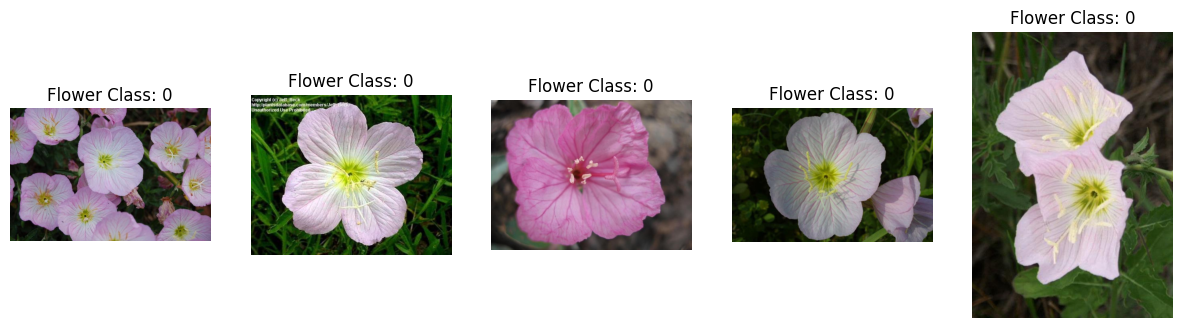

In [ ]:
import matplotlib.pyplot as plt

# Function to show a few sample images from the dataset
def preview_flowers(dataset, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        image, label = dataset[i]
        plt.subplot(1, num, i+1)
        plt.imshow(image)
        plt.title(f"Flower Class: {label}")
        plt.axis('off')
    plt.show()

preview_flowers(train_data)

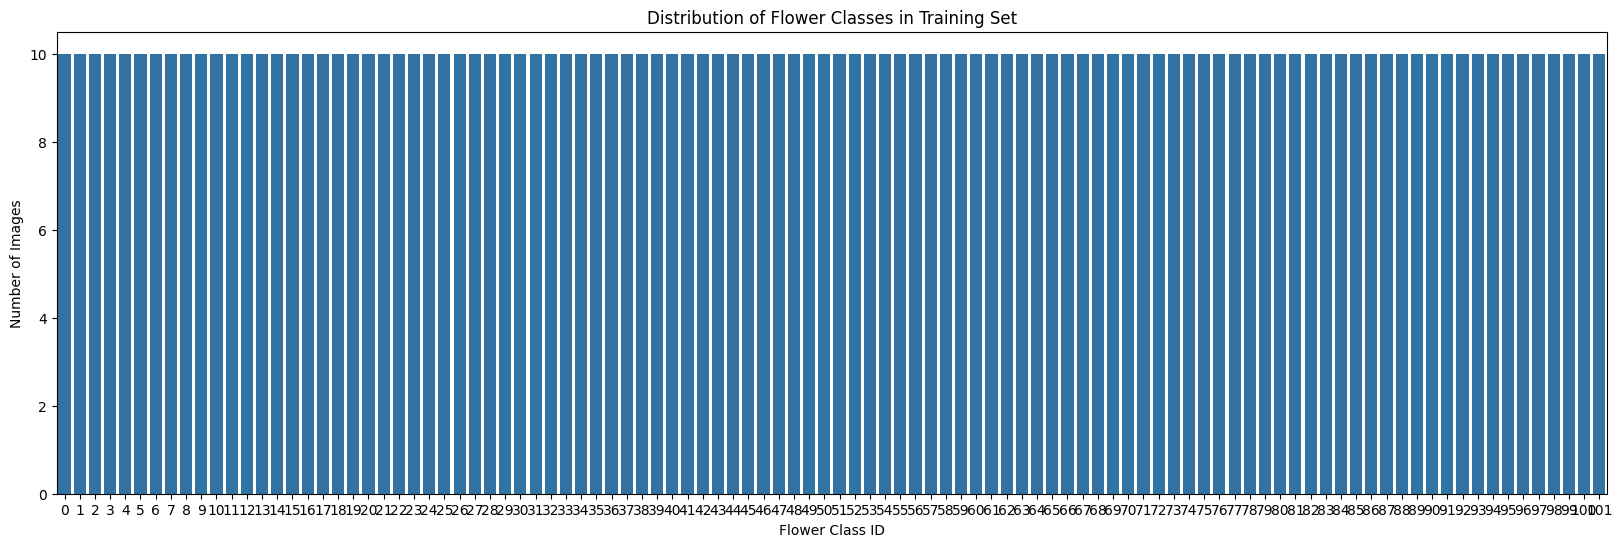

In [ ]:
import pandas as pd
import seaborn as sns

# Extract all labels from the training set
labels = [label for _, label in train_data]

# Create a chart to see if some flowers are more common than others
plt.figure(figsize=(20, 6))
sns.countplot(x=labels)
plt.title("Distribution of Flower Classes in Training Set")
plt.xlabel("Flower Class ID")
plt.ylabel("Number of Images")
plt.show()

Even distribution across flower class, all flowers class has 10 images across.


Data Quality issue:
- Small smaple size per category, possible overfitting
- Intraclass variance: camera angle, zoom level, lighting, camera orientation
- Background noise from grass
- Inconsistent picture format, recommended 1:1 square

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# 1. Define the rules for preparing the data
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224), # Handles different scales and framing
    transforms.RandomHorizontalFlip(), # Flips image left-to-right
    transforms.RandomRotation(15),     # Handles flowers at different angles
    transforms.ToTensor(),             # Converts image to numbers (Tensors)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Standard normalization
])

# For Validation and Test, we only resize/center crop (no random flipping)
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 2. Apply the transforms to your existing datasets
train_data.transform = train_transforms
val_data.transform = val_test_transforms
test_data.transform = val_test_transforms

# 3. Create DataLoaders (The "Conveyor Belt" for the T4 GPU)
# Batch size of 32 means the GPU processes 32 images at once
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Data Pipeline complete. Batches in train_loader: {len(train_loader)}")

Data Pipeline complete. Batches in train_loader: 32


Comment:
1. Standardardized Input:
- Resize image to 256 x 256 then 224 x 224, ensuring consistent input tensor for the pre-trained model
2. Limited data :
- Random image transformation to create variety in data.
3. Normalizing data:
- Ensuring flower image are compatible with pre-trained weights of the model
4. Improved hardware utilization:
- different batch sizes to reduce training time, avoid learning in order of classes and uses parallel image processing

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights
import copy

# 1. Reproducibility: Handle random seeds [Requirement 2.2.4]
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. Model Initialization & Fine-tuning [Requirement 2.1]
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False # Freeze layers

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102) # Modify head for 102 flower classes
model = model.to(device)

# 3. Training Infrastructure Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# 4. Integrated Training Loop with Metrics, Checkpointing, and Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        current_lr = optimizer.param_groups[0]['lr'] # Get Learning Rate [Requirement 2.2.2]

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * train_correct / train_total # Calculate Accuracy [Requirement 2.2.2]

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total # Calculate Val Accuracy [Requirement 2.2.2]
        scheduler.step(val_loss) # LR Scheduling [Requirement 2.1.3]

        # --- LOGGING [Requirement 2.2.2] ---
        print(f'Epoch {epoch}/{num_epochs-1} | LR: {current_lr:.6f} | '
              f'Train Loss: {epoch_loss:.4f}, Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

        # --- CHECKPOINTING [Requirement 2.2.1] ---
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
            early_stop_counter = 0
        else:
            # --- EARLY STOPPING [Requirement 2.2.1] ---
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts)
    return model

# Execute
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 86.9MB/s]


Epoch 0/19 | LR: 0.001000 | Train Loss: 4.4566, Acc: 8.43% | Val Loss: 3.9390, Acc: 46.27%
Epoch 1/19 | LR: 0.001000 | Train Loss: 3.6936, Acc: 51.67% | Val Loss: 3.3928, Acc: 63.63%
Epoch 2/19 | LR: 0.001000 | Train Loss: 3.1033, Acc: 69.31% | Val Loss: 2.9043, Acc: 72.16%
Epoch 3/19 | LR: 0.001000 | Train Loss: 2.6273, Acc: 74.71% | Val Loss: 2.5434, Acc: 73.82%
Epoch 4/19 | LR: 0.001000 | Train Loss: 2.2929, Acc: 80.59% | Val Loss: 2.2413, Acc: 75.98%
Epoch 5/19 | LR: 0.001000 | Train Loss: 2.0167, Acc: 82.55% | Val Loss: 2.0014, Acc: 77.65%
Epoch 6/19 | LR: 0.001000 | Train Loss: 1.7707, Acc: 82.65% | Val Loss: 1.8525, Acc: 77.75%
Epoch 7/19 | LR: 0.001000 | Train Loss: 1.5938, Acc: 84.02% | Val Loss: 1.7077, Acc: 79.71%
Epoch 8/19 | LR: 0.001000 | Train Loss: 1.4190, Acc: 86.27% | Val Loss: 1.5660, Acc: 80.29%
Epoch 9/19 | LR: 0.001000 | Train Loss: 1.2688, Acc: 88.14% | Val Loss: 1.4489, Acc: 81.57%
Epoch 10/19 | LR: 0.001000 | Train Loss: 1.1325, Acc: 90.29% | Val Loss: 1.3294, 

2.1
Model selection:
- RestNet50: Solves vanishing gradient problem
- More effecient on T4 GPU
- EfficientNet: slower training
- ViT: Too little data to train on

Fine tuning strategy:
- Backbone freezing : used to leverage pre-trained ImageNet weights
- Learn Rate scheduling: to ensure once model reached performance limit, learning rate decreases to allow for finer weight adjustments.


Training Infrastructure:
- Early stopping: Used validation_loss to stop training if loss did not improve over rounds
- Model checkpointing: implemented best_model.pth to save best model weights when validation loss reached a new minimum.
- Random seetds set at 42 at the start of script
- Class imbalance ignored since all class are exactly the same.



Evaluating on Test Set...

--- Final Test Metrics ---
Accuracy:  0.8307
Precision: 0.8503 (Weighted)
Recall:    0.8307 (Weighted)
F1-Score:  0.8272 (Weighted)


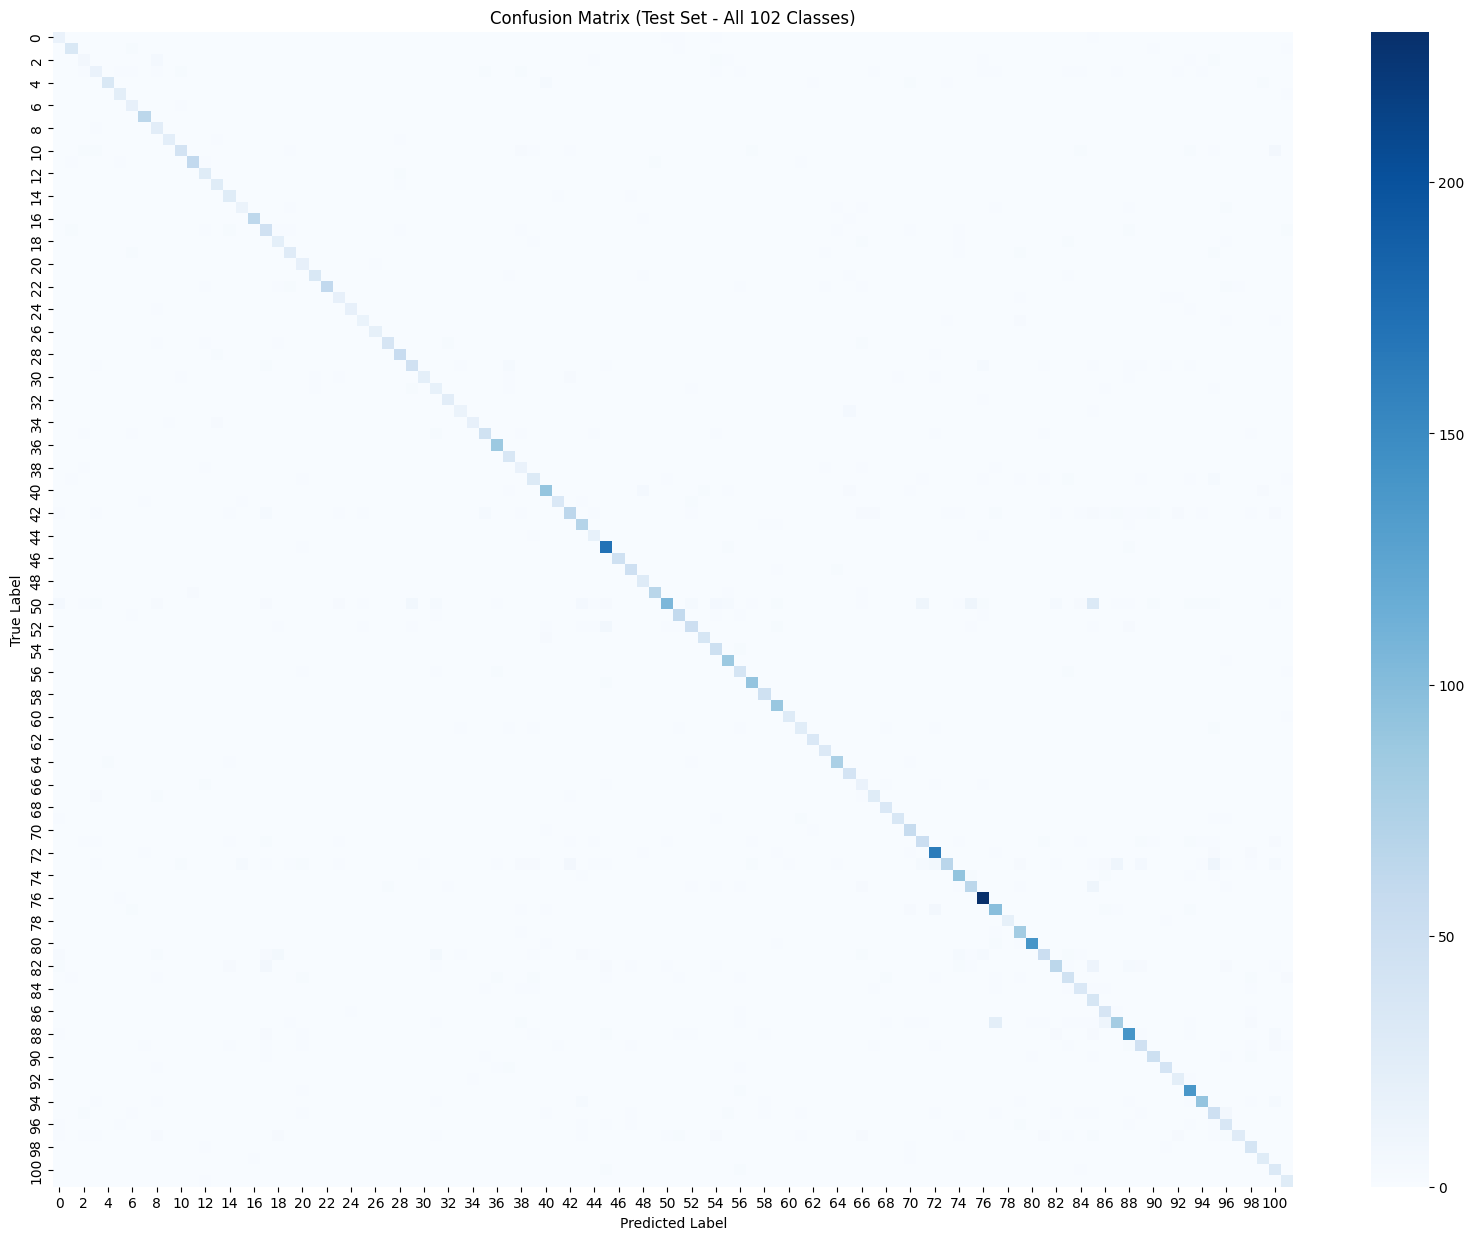


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.80      0.63        20
           1       0.88      0.88      0.88        40
           2       0.41      0.35      0.38        20
           3       0.53      0.44      0.48        36
           4       0.95      0.78      0.85        45
           5       0.86      0.96      0.91        25
           6       0.66      0.95      0.78        20
           7       0.96      1.00      0.98        65
           8       0.54      0.96      0.69        26
           9       0.96      0.92      0.94        25
          10       0.88      0.64      0.74        67
          11       0.95      0.91      0.93        67
          12       0.75      0.93      0.83        29
          13       0.82      0.96      0.89        28
          14       0.75      0.93      0.83        29
          15       0.74      0.67      0.70        21
          16       0.98      0.97      0.98     

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# 1. Load the Best Model Weights [Requirement 2.2.1]
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

# 2. Run Inference on the Test Set [Requirement 3.1]
print("Evaluating on Test Set...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Calculate Quantitative Metrics [Requirement 3.1.1]
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

print(f"\n--- Final Test Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (Weighted)")
print(f"Recall:    {recall:.4f} (Weighted)")
print(f"F1-Score:  {f1:.4f} (Weighted)")

# 4. Generate Confusion Matrix [Requirement 3.1.2]
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Set - All 102 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 5. Full Report for Analysis [Requirement 3.2]
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds))

Part 3 Evaluation and analysis.

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.80      0.63        20
           1       0.88      0.88      0.88        40
           2       0.41      0.35      0.38        20
           3       0.53      0.44      0.48        36
           4       0.95      0.78      0.85        45
           5       0.86      0.96      0.91        25
           6       0.66      0.95      0.78        20
           7       0.96      1.00      0.98        65
           8       0.54      0.96      0.69        26
           9       0.96      0.92      0.94        25
          10       0.88      0.64      0.74        67
          11       0.95      0.91      0.93        67
          12       0.75      0.93      0.83        29
          13       0.82      0.96      0.89        28
          14       0.75      0.93      0.83        29
          15       0.74      0.67      0.70        21
          16       0.98      0.97      0.98        65
          17       0.63      0.74      0.68        62
          18       0.63      0.76      0.69        29
          19       0.80      0.78      0.79        36
          20       0.63      0.95      0.76        20
          21       0.95      0.90      0.92        39
          22       1.00      0.86      0.92        71
          23       0.73      0.86      0.79        22
          24       0.95      0.90      0.93        21
          25       0.83      0.71      0.77        21
          26       0.95      1.00      0.98        20
          27       0.95      0.85      0.90        46
          28       0.92      0.95      0.93        58
          29       0.81      0.71      0.75        65
          30       0.96      0.69      0.80        32
          31       0.50      0.72      0.59        25
          32       0.89      0.96      0.93        26
          33       0.82      0.70      0.76        20
          34       0.95      0.83      0.88        23
          35       0.85      0.82      0.83        55
          36       0.93      1.00      0.96        88
          37       0.77      1.00      0.87        36
          38       0.50      0.76      0.60        21
          39       0.72      0.66      0.69        47
          40       0.88      0.85      0.87       107
          41       0.94      0.87      0.91        39
          42       0.83      0.58      0.68       110
          43       0.80      0.96      0.88        73
          44       0.69      0.90      0.78        20
          45       0.87      0.97      0.92       176
          46       1.00      1.00      1.00        47
          47       0.91      0.94      0.92        51
          48       0.78      1.00      0.88        29
          49       0.97      0.93      0.95        72
          50       0.95      0.45      0.61       238
          51       0.88      0.92      0.90        65
          52       0.82      0.68      0.75        73
          53       0.95      0.93      0.94        41
          54       0.74      0.96      0.84        51
          55       0.89      0.99      0.94        89
          56       0.73      0.85      0.78        47
          57       0.94      0.98      0.96        94
          58       0.92      1.00      0.96        47
          59       0.92      1.00      0.96        89
          60       0.97      0.97      0.97        30
          61       0.84      0.74      0.79        35
          62       0.94      1.00      0.97        34
          63       0.91      1.00      0.96        32
          64       0.94      0.94      0.94        82
          65       0.80      1.00      0.89        41
          66       0.43      0.73      0.54        22
          67       0.82      0.79      0.81        34
          68       0.87      1.00      0.93        34
          69       0.97      0.86      0.91        42
          70       0.82      0.97      0.89        58
          71       0.75      0.68      0.72        76
          72       0.89      0.94      0.91       174
          73       0.96      0.44      0.60       151
          74       0.87      0.93      0.90       100
          75       0.81      0.75      0.78        87
          76       0.93      1.00      0.96       231
          77       0.73      0.84      0.78       117
          78       1.00      0.95      0.98        21
          79       0.84      0.98      0.90        85
          80       0.99      0.97      0.98       146
          81       0.85      0.57      0.68        92
          82       0.87      0.59      0.70       111
          83       0.75      0.68      0.71        66
          84       0.74      0.79      0.76        43
          85       0.35      1.00      0.51        38
          86       0.65      0.91      0.76        43
          87       0.83      0.61      0.70       134
          88       0.87      0.86      0.87       164
          89       0.75      0.74      0.75        62
          90       0.89      0.88      0.88        56
          91       0.91      0.89      0.90        46
          92       0.75      0.92      0.83        26
          93       0.89      0.98      0.93       142
          94       0.94      0.85      0.89       108
          95       0.59      0.68      0.63        71
          96       0.61      0.78      0.69        46
          97       0.97      0.45      0.62        62
          98       0.70      0.93      0.80        43
          99       0.84      0.93      0.89        29
         100       0.52      0.87      0.65        38
         101       0.71      0.96      0.82        28

    accuracy                           0.83      6149
   macro avg       0.82      0.85      0.82      6149
weighted avg       0.85      0.83      0.83      6149

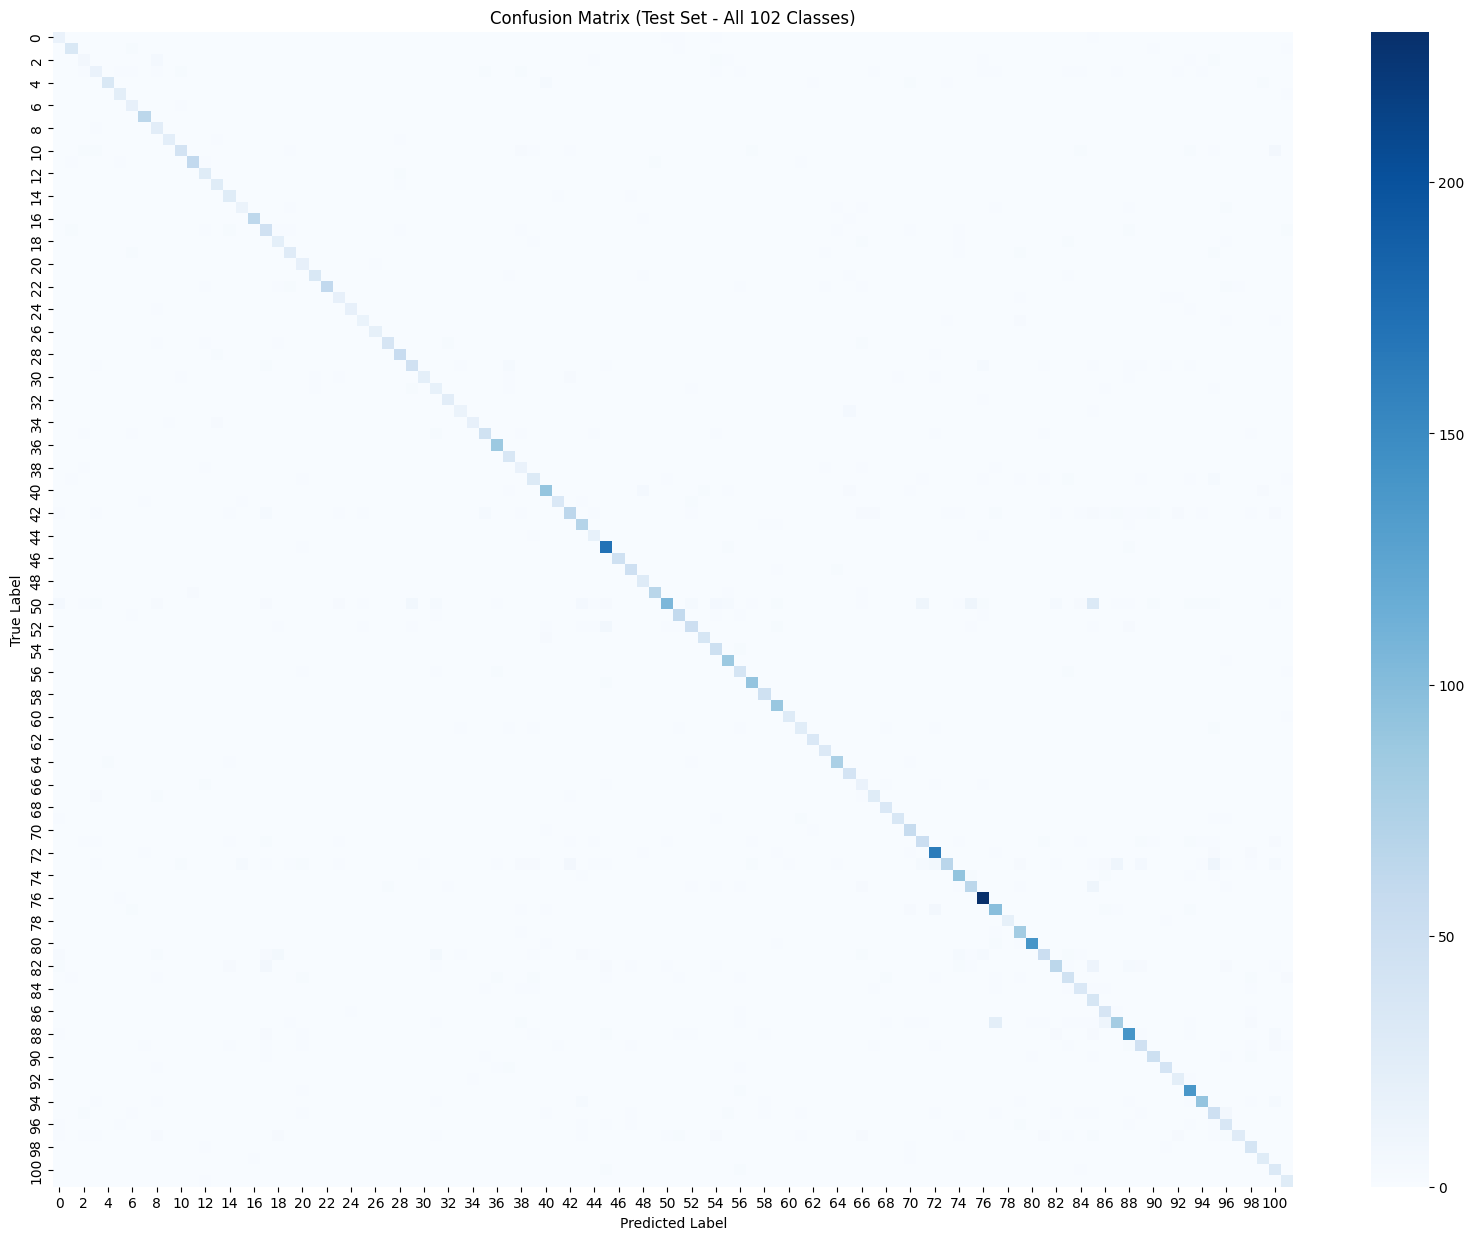


Analysis of confusion matrix:
- Minimal noise, most results fall under remain within diagonal line
- Classes with highest success are 46,76, 80.
- X axis shows the predicted label (using ResNet-50)
- Y axis shows ground truth from the dataset
- Overall results were very accurate.

Generating probabilities for ROC curves...


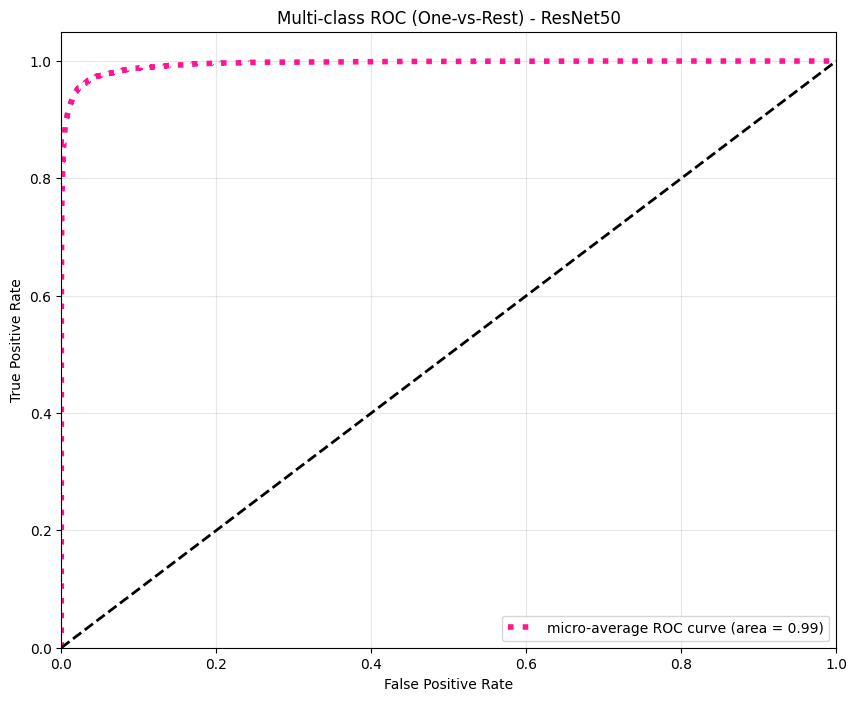

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect probabilities and true labels
model.eval()
all_probs = []
all_labels = []

print("Generating probabilities for ROC curves...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Convert raw logits to probabilities
        probs = F.softmax(outputs, dim=1)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

# 2. Binarize labels for 102 classes
y_test_bin = label_binarize(all_labels, classes=range(102))

# 3. Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(102):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Compute Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 5. Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC (One-vs-Rest) - ResNet50')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png') # Required per guidelines

ROC Curve Analysis:
- High true positive rate even at low false positive threshold
- SHows that the results is good at ranking right answers near top.
- 0.99 proves that ResNet50 actually did learn the difference between species, the model is reliable at ranking correct species highly.

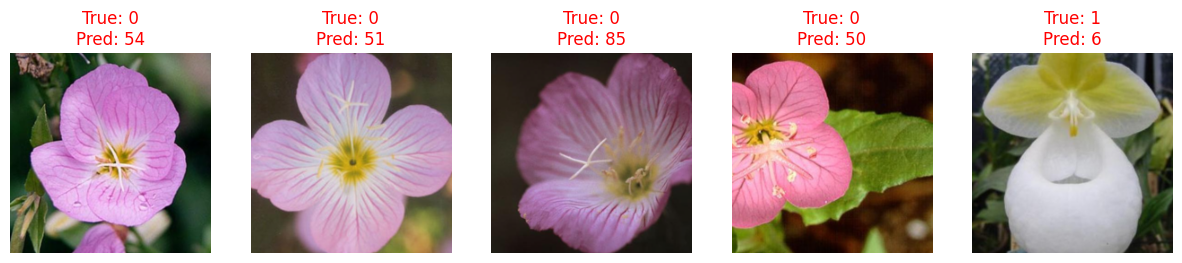

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_errors(model, test_loader, device, num_images=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find indices where prediction doesn't match label
            wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]

            for i in wrong_idx:
                if len(errors) < num_images:
                    errors.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                else:
                    break
            if len(errors) >= num_images: break

    # Plotting the errors
    plt.figure(figsize=(15, 5))
    for i, (img, label, pred) in enumerate(errors):
        img = img.permute(1, 2, 0).numpy()
        # Un-normalize for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"True: {label.item()}\nPred: {pred.item()}", color='red')
        plt.axis('off')
    plt.show()

visualize_errors(model, test_loader, device)

Error Analysis:
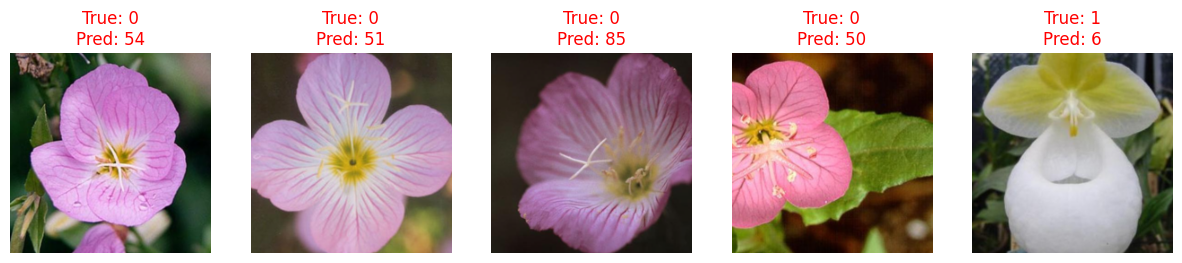


- Most common misclassificationsdue to semantic overlap. All pink flowers, but missing further details to distinguish them (such as stamen shape or leaf texture)
- Cropped images affects the full symmetry of petals, affected perfomance.
- Suggestions:
  - Increase image resolution to see finer details such as stamen and petal veins.
  - Take multiple crops and flips of same image and average the prediction to improve the performance
  - Implement label smoothing to improve training data
  - Use vision transformer to help focus on the center of flower

Part 3.3 Model Analysis

Performance vs dataset complexity
- With a test accuracy of 83.07% and ROC of 0.99, this is a strong result given the limited training data. The Oxford 102 flower dataset shows that the interclass variance is extremely low and the interclass variance is high (many species looking near identical and some of the same species can look different due to lighting)

Trade-off analysis
- ResNet-50 was chosen due to its optimal balance for research application.
- ResNet-50 is also significantly faster compared to vision transformers, making it more suitable for real-time identification.
- Model size is sufficient to fit into memory-constrained environments, and while it provides sufficient accuracy.
- ResNet-50 does provide enough accuracy. While a larger model might increase the performance and accuracy, the cost in terms of increased latency and power consumption would not be a good trade-off. (since test accuracy at 83.07% and ROC at 0.99)

Hyperparameter Tuning Experiments
- The first strategy was to implement backbone freezing. This is so that ImageNet would learn the features early on in the training phase.
- The second strategy implemented was the learning rate scheduling. This allowed the model to use higher learning rates for rapid initial convergence and automatically drop the rate when validation loss flattens.
- The third strategy implemented was early stopping. By setting patients of five epochs on validation loss, this prevented the model from overfitting on the small training set.

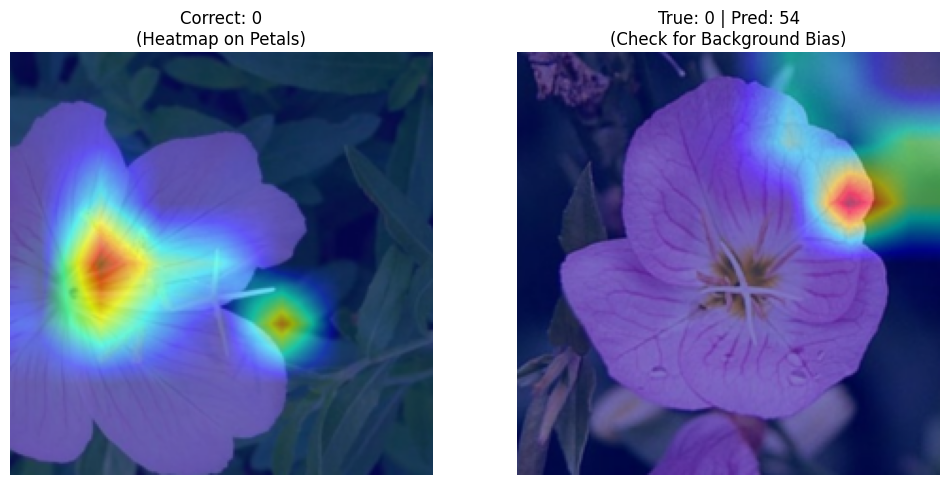

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image

# 1. Setup Grad-CAM
# For ResNet50, the last convolutional layer is model.layer4[-1]
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def get_gradcam_viz(img_tensor, target_category):
    # Ensure gradients are enabled for Grad-CAM
    with torch.set_grad_enabled(True):
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad = True # Ensure input can track gradients

        # Generate CAM map
        targets = [ClassifierOutputTarget(target_category)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Rest of the visualization code remains the same...
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    return visualization
# 2. Find samples to visualize
model.eval()
correct_sample = None
wrong_sample = None

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            if preds[i] == labels[i] and correct_sample is None:
                correct_sample = (inputs[i], labels[i].item(), preds[i].item())
            if preds[i] != labels[i] and wrong_sample is None:
                wrong_sample = (inputs[i], labels[i].item(), preds[i].item())
        if correct_sample and wrong_sample: break

# 3. Plot results
plt.figure(figsize=(12, 6))

# Correct Viz
plt.subplot(1, 2, 1)
viz_correct = get_gradcam_viz(correct_sample[0], correct_sample[1])
plt.imshow(viz_correct)
plt.title(f"Correct: {correct_sample[1]}\n(Heatmap on Petals)")
plt.axis('off')

# Wrong Viz
plt.subplot(1, 2, 2)
viz_wrong = get_gradcam_viz(wrong_sample[0], wrong_sample[2]) # Target the prediction
plt.imshow(viz_wrong)
plt.title(f"True: {wrong_sample[1]} | Pred: {wrong_sample[2]}\n(Check for Background Bias)")
plt.axis('off')

plt.show()

Correct: 0
Visualization:
- The model ignores the surrounding green leaves and background clutter. It's concluded that it's making the right decision.
- The result suggests that the model has successfully learned about the flower and its internal petal patterns.


True: 0, Pred:54
Visualization:
- The model did not successfully identify the center of the flower and identified a green leaf in the background instead.


Comments:
- The model demonstrates strong botanical feature extraction. This indicate that ResNet-50 backbone is suitable for fine-grained internal flower structures over global shapes.
- For the misclassified samples, this also highlights the downside of this model, which suggests that it occasionally relies on spatial context rather than the primary object.
- Further training with random erasing or mixup augmentation could help the model to look at more diverse parts of the flower rather than just the edges.

In [ ]:
import torch.nn.functional as F

def predict_flower(image_path, model, device, top_k=3):
    # Standard transformation used in Part 1/2
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        confidences, indices = torch.topk(probs, top_k)

    # Return exactly what is required by the brief [cite: 77-79]
    return {
        "predicted_class": indices[0][0].item(),
        "confidence_score": confidences[0][0].item(),
        "top_3": [(indices[0][i].item(), confidences[0][i].item()) for i in range(top_k)]
    }

In [ ]:
# 1. Get a sample image path from your test dataset
# test_data.imgs usually contains a list of (path, class_id)
sample_path, sample_label = test_data._image_files[0], test_data._labels[0]

# 2. Call the function you defined [Requirement 5.1]
print(f"Testing Inference on a sample image...")
inference_results = predict_flower(sample_path, model, device)

# 3. Explicitly print the output so it's visible to the recruiter [Requirement 106]
import json
print("\nFinal Output for Part 5:")
print(json.dumps(inference_results, indent=4))

Testing Inference on a sample image...

Final Output for Part 5:
{
    "predicted_class": 54,
    "confidence_score": 0.07567102462053299,
    "top_3": [
        [
            54,
            0.07567102462053299
        ],
        [
            94,
            0.07293152809143066
        ],
        [
            95,
            0.07107214629650116
        ]
    ]
}
